# **Lê Nguyễn Tuyết Nhi - 521h0364**
# **Trương Gia Bảo - 521h0201** 
# **Vi Thành Đạt - 521h0390**

# **Final Project** 

In [ ]:
!pip install datasets gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 51.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is inc

In [2]:
# Import libraries
import tensorflow as tf
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input, Attention, Concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
# Load dataset
dataset = load_dataset("opus100", "en-vi")
train_data = dataset["train"]

README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
# Extract sentences
vi_sentences_train = ['<sos>' + example["translation"]["vi"].lower() + '<eos>' for example in train_data]
en_sentences_train = ['<sos>' + example["translation"]["en"].lower() + '<eos>' for example in train_data]

# **Use 300,000 elements**

In [4]:
# Limit dataset size
max_dataset_size = 300000
vi_sentences_train = vi_sentences_train[:max_dataset_size]
en_sentences_train = en_sentences_train[:max_dataset_size]

In [5]:
vi_sentences_train[:1]

['<sos>cái gì đó?<eos>']

In [6]:
en_sentences_train[:1]

['<sos>what is it?<eos>']

In [ ]:
# Tokenization
# Giới hạn kích thước từ vựng và độ già câu
max_vocab_size = 60000
max_sequence_length = 30

# Gán các từ không trong kích thước thành nhãn unk
vi_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<unk>")
en_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<unk>")

vi_tokenizer.fit_on_texts(vi_sentences_train)
en_tokenizer.fit_on_texts(en_sentences_train)

# chuyển từ text sang dạng số
vi_sequences_train = pad_sequences(vi_tokenizer.texts_to_sequences(vi_sentences_train), maxlen=max_sequence_length, padding='post')
en_sequences_train = pad_sequences(en_tokenizer.texts_to_sequences(en_sentences_train), maxlen=max_sequence_length, padding='post')

In [8]:
# Step 2: Load Pre-trained FastText Embeddings
# Download and load FastText vectors
!wget -q -O wiki-news-300d-1M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip -q wiki-news-300d-1M.vec.zip

fasttext_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec', binary=False)
embedding_dim = 300

# Create embedding matrix
def create_embedding_matrix(tokenizer, embedding_dim, fasttext_model):
    n_words = len(tokenizer.word_index) + 1  # Include padding token
    embedding_matrix = np.zeros((n_words, embedding_dim))  # Initialize matrix with zeros

    for word, i in tokenizer.word_index.items():
        if word in fasttext_model.key_to_index:
            embedding_matrix[i] = fasttext_model[word]
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)  # Random initialization for OOV words
    return embedding_matrix

vi_embedding_matrix = create_embedding_matrix(vi_tokenizer, embedding_dim, fasttext_model)
en_embedding_matrix = create_embedding_matrix(en_tokenizer, embedding_dim, fasttext_model)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
# Step 3: Define the Encoder-Decoder Model
# Encoder
encoder_input = Input(shape=(max_sequence_length,), name="Encoder_Input")
encoder_embedding = Embedding(
    input_dim=len(vi_tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[vi_embedding_matrix],
    trainable=False,
    name="Encoder_Embedding"
)(encoder_input)
encoder_bilstm = Bidirectional(
    LSTM(128, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3), name="Encoder_BiLSTM"
)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedding)
state_h = Concatenate(name="Encoder_State_h")([forward_h, backward_h])
state_c = Concatenate(name="Encoder_State_c")([forward_c, backward_c])

# Input cho encoder
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(max_sequence_length,), name="Decoder_Input")
decoder_embedding = Embedding(
    input_dim=len(en_tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[en_embedding_matrix],
    trainable=False,
    name="Decoder_Embedding"
)(decoder_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3, name="Decoder_LSTM")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention(use_scale=True, name="Attention_Layer")
# Kết hợp đầu ra từ Decoder (decoder_outputs) với đầu ra từ Encoder (encoder_outputs) để tính trọng số.
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate Attention Output
# Kết hợp đầu ra từ Decoder (decoder_outputs) và Attention (attention_output).
decoder_concat = Concatenate(axis=-1, name="Concat_Layer")([decoder_outputs, attention_output])

# Dense Output Layer
decoder_dense = Dense(max_vocab_size, activation="softmax", name="Output_Layer")
decoder_outputs = decoder_dense(decoder_concat)

# Define Model
model = Model([encoder_input, decoder_input], decoder_outputs, name="BiLSTM_Encoder-Decoder_Model")

# Compile Model
learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "BiLSTM_Encoder-Decoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding   │ (None, 30, 300)   │ 10,559,100 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_BiLSTM      │ [(None, 30, 256), │    439,296 │ Encoder_Embeddin… │
│ (Bidirectional)     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, 30, 300)   │ 16,146,300 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_State_h     │ (None, 256)       │          0 │ Encoder_BiLSTM[0… │
│ (Concatenate)       │                   │            │ Encoder_BiLSTM[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_State_c     │ (None, 256)       │          0 │ Encoder_BiLSTM[0… │
│ (Concatenate)       │                   │            │ Encoder_BiLSTM[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM (LSTM) │ [(None, 30, 256), │    570,368 │ Decoder_Embeddin… │
│                     │ (None, 256),      │            │ Encoder_State_h[… │
│                     │ (None, 256)]      │            │ Encoder_State_c[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_Layer     │ (None, 30, 256)   │          1 │ Decoder_LSTM[0][… │
│ (Attention)         │                   │            │ Encoder_BiLSTM[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_Layer        │ (None, 30, 512)   │          0 │ Decoder_LSTM[0][… │
│ (Concatenate)       │                   │            │ Attention_Layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 30, 60000) │ 30,780,000 │ Concat_Layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,495,065 (223.14 MB)

 Trainable params: 31,789,665 (121.27 MB)

 Non-trainable params: 26,705,400 (101.87 MB)

In [10]:
# Prepare Decoder Inputs and Targets
decoder_input_data_train = np.zeros_like(en_sequences_train)
decoder_input_data_train[:, 1:] = en_sequences_train[:, :-1]  # Shift by one position
decoder_target_data_train = np.zeros_like(en_sequences_train)
decoder_target_data_train[:, :-1] = en_sequences_train[:, 1:]  # Shift target by one position

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [11]:
# Train Model
history = model.fit(
    [vi_sequences_train, decoder_input_data_train],
    decoder_target_data_train,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1562s 415ms/step - accuracy: 0.7773 - loss: 1.7779 - val_accuracy: 0.7950 - val_loss: 1.3754
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1559s 416ms/step - accuracy: 0.7972 - loss: 1.3286 - val_accuracy: 0.8051 - val_loss: 1.2619
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1563s 417ms/step - accuracy: 0.8056 - loss: 1.2084 - val_accuracy: 0.8109 - val_loss: 1.2038
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1563s 417ms/step - accuracy: 0.8098 - loss: 1.1347 - val_accuracy: 0.8139 - val_loss: 1.1741
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1563s 417ms/step - accuracy: 0.8129 - loss: 1.0785 - val_accuracy: 0.8158 - val_loss: 1.1580
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1564s 417ms/step - accuracy: 0.8161 - loss: 1.0349 - val_accuracy: 0.8175 - val_loss: 1.1472
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1566s 417ms/step - accuracy: 0.8183 - loss: 1.0029 - val_accuracy: 0.8183 - val_loss: 1.1427
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1565s 417ms/s

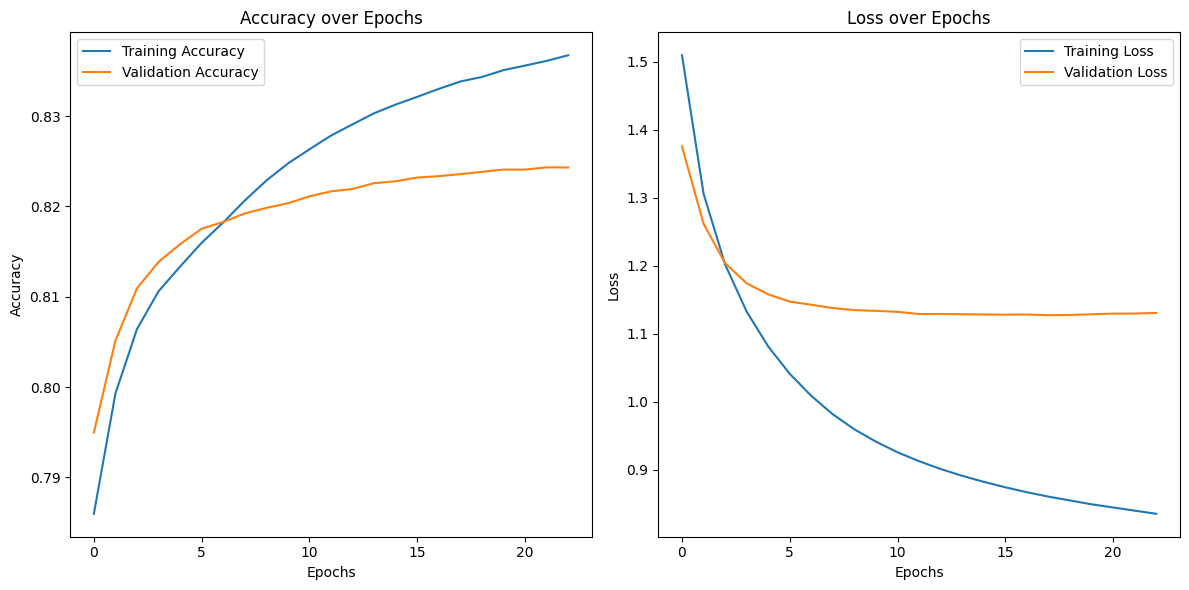

In [12]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
def translate_with_attention(vi_sentence):
    # Preprocess input sentence
    sequence = vi_tokenizer.texts_to_sequences(['<sos> ' + vi_sentence + ' <eos>'])
    sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')

    # Initialize decoder input
    decoder_input = np.zeros((1, max_sequence_length))
    decoder_input[0, 0] = en_tokenizer.word_index.get('<sos>', 1)

    translated_sentence = []
    attention_weights = []

    for i in range(max_sequence_length - 1):
        # Predict the next token
        prediction = model.predict([sequence, decoder_input], verbose=0)
        predicted_id = np.argmax(prediction[0, i])

        # Save attention weights
        attention_weights.append(prediction[0, i])

        # Stop if <eos> token is predicted
        if predicted_id == en_tokenizer.word_index.get('<eos>', 0) or predicted_id == 0:
            break

        # Append the predicted word to the translated sentence
        translated_sentence.append(en_tokenizer.index_word.get(predicted_id, '<unk>'))
        decoder_input[0, i + 1] = predicted_id

    return ' '.join(translated_sentence), np.array(attention_weights)


In [14]:
# Example
vi_sentence = "xin chào"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: xin chào
Translated: hello


In [15]:
# Example
vi_sentence = "cảm ơn"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: cảm ơn
Translated: thank


In [16]:
# Example
vi_sentence = "tạm biệt"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: tạm biệt
Translated: bye


In [17]:
# Example
vi_sentence = "hôm nay là thứ hai"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: hôm nay là thứ hai
Translated: today is second
